<a href="https://colab.research.google.com/github/Aomaphisara/bsc_dpdm22/blob/main/Mid_BPDM22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#การเตรียมข้อมูลประกอบด้วย กำจัด outlier, แก้ missing, normalization, one-hot-encoder และ อื่นๆ ที่นักศึกษาเห็นว่าเหมาะสม

# 1 ทำนายราคาบ้าน 10 คะแนน
เตรียมข้อมูลเพื่อทำนายราคาบ้าน ราคาประเมินบ้าน และ คะแนนทรัพย์ จาก [google drive](https://drive.google.com/drive/folders/1uIcUFY1yldIq-A3wijh2n2N6az-EljIe?usp=sharing) โดยข้อมูลที่เตรียมต้องประกอบด้วย columns ต่อไปนี้

* ```'renovate','number_of_rai','number_of_ngan','number_of_va','number_of_story','number_of_bedroom','number_of_bathroom','direction','furniture','usable_area','number_of_parking', 'sell_price'``` จากตาราง "คำตอบนักประเมิน(ID)"

* ```จำนวน 7-11 และ โรงเรียน ในรัศมี 200,500,1000,2000 เมตร (ตั้งชื่อ d200-7/11','d500-7/11',...,'d2000-7/11' แบะ ;d200-school','d500-school',...,'d2000-school')``` จากตาราง "7-eleven.json" และ "school.json"

* ```ประเมินราคาซื้อขาย และ คะแนนทรัพย์ (ตั้งชื่อ 'estimator' และ 'score')``` จากตาราง คำตอบนักประเมิน(ID) โดยราคาประเมินกับคะแนนทรัพย์ อ้างอิงของนักประเมิน ID=01 คนเดียว

In [28]:
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
mpl.rc('font', family='TH Sarabun New')

In [29]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import json
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [30]:

/#เชื่อม google drive 
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import os
os.chdir('/content/drive/MyDrive/Mid BPDM')

#Data House

## บ้านมือ 2

In [32]:
link = 'https://docs.google.com/spreadsheets/d/1REdJzoGqhVn3fnM1I0GoSLzzeW2dAr2UNo1b64hNbJY/export?format=xlsx'
home2 = pd.read_excel(link,sheet_name='บ้านมือ2')
home2.head()


,id,name_th,name_en,project_name,company,province,district,sub_district,property_type,home improvement,...,furniture,building_number,number_of_building,floor_number,parking_percentage,has_pool,has_keycard,has_security,has_fitness,has_garden
0,1.0,บ้านเดี่ยว ชนบท ขอนแก่น,บ้านเดี่ยว ชนบท ขอนแก่น,บ้านวังเวิน,NaN,ขอนแก่น,ชนบท,ศรีบุญเรือง,บ้านเดี่ยว,no,...,ไม่มี,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,บ้านเดี่ยว น้ำพอง ขอนแก่น,บ้านเดี่ยว น้ำพอง ขอนแก่น,บ้านหนองบัวบาน,NaN,ขอนแก่น,น้ำพอง,ทรายมูล,บ้านเดี่ยว,no,...,ไม่มี,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16.0,บ้านเดี่ยว มัญจาคีรี ขอนแก่น,บ้านเดี่ยว มัญจาคีรี ขอนแก่น,NaN,NaN,ขอนแก่น,มัญจาคีรี,กุดเค้า,บ้านเดี่ยว,no,...,ไม่ระบุ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18.0,บ้านเดี่ยว เมืองขอนแก่น หมู่บ้านชลลดา,บ้านเดี่ยว เมืองขอนแก่น หมู่บ้านชลลดา,ชลลดา ขอนแก่น,บริษัท แลนด์แอนด์เฮ้าส์ จำกัด (มหาชน),ขอนแก่น,เมืองขอนแก่น,บ้านเป็ด,บ้านเดี่ยว,no,...,ไม่ระบุ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19.0,บ้านเดี่ยว เมืองขอนแก่น หมู่บ้านเบสต์โฮม,บ้านเดี่ยว เมืองขอนแก่น หมู่บ้านเบสต์โฮม,เบสท์โฮม,เบสท์โฮม เลี่ยงเมืองขอนแก่น,ขอนแก่น,เมืองขอนแก่น,บ้านเป็ด,บ้านเดี่ยว,no,...,ไม่ระบุ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
home2.columns

Index(['id', 'name_th', 'name_en', 'project_name', 'company', 'province',
       'district', 'sub_district', 'property_type', 'home improvement',
       'renovate', 'public utility', 'land type', 'land wide(m)',
       'land long(m)', 'topsoil', 'corner', 'zip_code', 'zone', 'alley',
       'street', 'latitude', 'longitude', 'number_of_rai', 'number_of_ngan',
       'number_of_va', 'construct_year', 'model', 'sell_price',
       'number_of_unit', 'number_of_story', 'number_of_bedroom',
       'number_of_bathroom', 'number_of_parking', 'usable_area',
       'central_cost', 'direction', 'furniture', 'building_number',
       'number_of_building', 'floor_number', 'parking_percentage', 'has_pool',
       'has_keycard', 'has_security', 'has_fitness', 'has_garden'],
      dtype='object')

In [34]:
home2 = home2[['renovate','number_of_rai','number_of_ngan','number_of_va','number_of_story','number_of_bedroom','number_of_bathroom','direction','furniture','usable_area','number_of_parking', 'sell_price']]

In [35]:
home2.head()

,renovate,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price
0,no,0.0,1.0,45.0,2.0,2.0,2.0,ไม่ระบุ,ไม่มี,244.0,2.0,390000.0
1,no,0.0,0.0,88.0,1.0,1.0,1.0,ไม่ระบุ,ไม่มี,164.0,3.0,820000.0
2,no,1.0,0.0,8.0,1.0,11.0,11.0,ไม่ระบุ,ไม่ระบุ,489.0,9.0,3260000.0
3,no,0.0,0.0,61.6,2.0,3.0,3.0,ไม่ระบุ,ไม่ระบุ,203.0,2.0,5000000.0
4,no,0.0,0.0,72.3,2.0,3.0,2.0,ไม่ระบุ,ไม่ระบุ,164.0,2.0,3500000.0


In [36]:
home2['second_hand'] = 'บ้านมือ2'     

<ipython-input-36-2d640b3f91e8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home2['second_hand'] = 'บ้านมือ2'


In [37]:
home2

,renovate,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,second_hand
0,no,0.0,1.0,45.0,2.0,2.0,2.0,ไม่ระบุ,ไม่มี,244.00,2.0,390000.0,บ้านมือ2
1,no,0.0,0.0,88.0,1.0,1.0,1.0,ไม่ระบุ,ไม่มี,164.00,3.0,820000.0,บ้านมือ2
2,no,1.0,0.0,8.0,1.0,11.0,11.0,ไม่ระบุ,ไม่ระบุ,489.00,9.0,3260000.0,บ้านมือ2
3,no,0.0,0.0,61.6,2.0,3.0,3.0,ไม่ระบุ,ไม่ระบุ,203.00,2.0,5000000.0,บ้านมือ2
4,no,0.0,0.0,72.3,2.0,3.0,2.0,ไม่ระบุ,ไม่ระบุ,164.00,2.0,3500000.0,บ้านมือ2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651,no,0.0,0.0,73.0,1.0,2.0,1.0,ไม่ระบุ,ไม่ระบุ,108.76,NaN,437400.0,บ้านมือ2
1652,no,0.0,0.0,84.0,1.0,2.0,1.0,ไม่ระบุ,ไม่ระบุ,119.00,NaN,714600.0,บ้านมือ2
1653,no,0.0,1.0,45.0,2.0,1.0,1.0,ไม่ระบุ,ไม่ระบุ,188.50,NaN,451000.0,บ้านมือ2
1654,no,0.0,1.0,59.0,2.0,1.0,1.0,ไม่ระบุ,ไม่ระบุ,207.00,NaN,910000.0,บ้านมือ2


In [38]:
home2.isnull().any()  #falseคือไม่มีค่าว่าง trueคือมีค่าว่าง

renovate               True
number_of_rai         False
number_of_ngan        False
number_of_va          False
number_of_story        True
number_of_bedroom      True
number_of_bathroom    False
direction             False
furniture             False
usable_area            True
number_of_parking      True
sell_price             True
second_hand           False
dtype: bool

In [39]:
print(home2.isnull().sum()) 

renovate              211
number_of_rai           0
number_of_ngan          0
number_of_va            0
number_of_story       549
number_of_bedroom      27
number_of_bathroom      0
direction               0
furniture               0
usable_area           920
number_of_parking     215
sell_price              1
second_hand             0
dtype: int64


## ลบ Missing บ้านมือ 2

In [40]:
dhome2 = home2.dropna()
dhome2

,renovate,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,second_hand
0,no,0.0,1.0,45.0,2.0,2.0,2.0,ไม่ระบุ,ไม่มี,244.0,2.0,390000.0,บ้านมือ2
1,no,0.0,0.0,88.0,1.0,1.0,1.0,ไม่ระบุ,ไม่มี,164.0,3.0,820000.0,บ้านมือ2
2,no,1.0,0.0,8.0,1.0,11.0,11.0,ไม่ระบุ,ไม่ระบุ,489.0,9.0,3260000.0,บ้านมือ2
3,no,0.0,0.0,61.6,2.0,3.0,3.0,ไม่ระบุ,ไม่ระบุ,203.0,2.0,5000000.0,บ้านมือ2
4,no,0.0,0.0,72.3,2.0,3.0,2.0,ไม่ระบุ,ไม่ระบุ,164.0,2.0,3500000.0,บ้านมือ2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436,no,0.0,0.0,85.0,2.0,4.0,3.0,ไม่ระบุ,มีบางส่วน,180.0,2.0,4800000.0,บ้านมือ2
1437,no,0.0,0.0,64.0,1.0,2.0,2.0,ไม่ระบุ,ไม่ระบุ,64.0,2.0,2500000.0,บ้านมือ2
1438,no,0.0,0.0,100.0,1.0,3.0,1.0,ไม่ระบุ,ไม่ระบุ,80.0,2.0,2000000.0,บ้านมือ2
1475,no,0.0,0.0,56.2,2.0,3.0,3.0,ไม่ระบุ,ไม่ระบุ,222.0,2.0,2990000.0,บ้านมือ2


In [41]:
dhome2.isnull().any() 

renovate              False
number_of_rai         False
number_of_ngan        False
number_of_va          False
number_of_story       False
number_of_bedroom     False
number_of_bathroom    False
direction             False
furniture             False
usable_area           False
number_of_parking     False
sell_price            False
second_hand           False
dtype: bool

## บ้านมือ 1

In [42]:
link = 'https://docs.google.com/spreadsheets/d/1REdJzoGqhVn3fnM1I0GoSLzzeW2dAr2UNo1b64hNbJY/export?format=xlsx'
home1 = pd.read_excel(link,sheet_name='บ้านมือ1')
home1.head()

,id,parent_id,project_name,province,district,sub_district,zip_code,zone_id,zone,property_type,...,cable_free,cable_none,cable_ask,position_previous,position_current,sold_out_at,is_pro_in_house,created_at,updated_at,deleted_at
0,314.0,41.0,ที สเปซ กลางเมือง,ขอนแก่น,เมืองขอนแก่น,เมืองเก่า,NaN,5.0,กลางเมือง-เมืองเก่า-กุดกว้าง,บ้านเดี่ยว,...,NaN,NaN,NaN,0.0,0.0,NaN,0.0,44012.0,44602.0,NaN
1,315.0,41.0,ที สเปซ กลางเมือง,ขอนแก่น,เมืองขอนแก่น,เมืองเก่า,NaN,5.0,กลางเมือง-เมืองเก่า-กุดกว้าง,บ้านแฝด,...,NaN,NaN,NaN,0.0,0.0,NaN,0.0,44012.0,44602.0,NaN
2,316.0,41.0,ที สเปซ กลางเมือง,ขอนแก่น,เมืองขอนแก่น,เมืองเก่า,NaN,5.0,กลางเมือง-เมืองเก่า-กุดกว้าง,บ้านเดี่ยว,...,NaN,NaN,NaN,0.0,0.0,NaN,0.0,44012.0,44602.0,NaN
3,317.0,41.0,ที สเปซ กลางเมือง,ขอนแก่น,เมืองขอนแก่น,เมืองเก่า,NaN,5.0,กลางเมือง-เมืองเก่า-กุดกว้าง,บ้านเดี่ยว,...,NaN,NaN,NaN,0.0,0.0,NaN,0.0,44012.0,44602.0,NaN
4,318.0,41.0,ที สเปซ กลางเมือง,ขอนแก่น,เมืองขอนแก่น,เมืองเก่า,NaN,5.0,กลางเมือง-เมืองเก่า-กุดกว้าง,บ้านเดี่ยว,...,NaN,NaN,NaN,0.0,0.0,NaN,0.0,44012.0,44602.0,NaN


In [43]:
home1.columns

Index(['id', 'parent_id', 'project_name', 'province', 'district',
       'sub_district', 'zip_code', 'zone_id', 'zone', 'property_type',
       ...
       'cable_free', 'cable_none', 'cable_ask', 'position_previous',
       'position_current', 'sold_out_at', 'is_pro_in_house', 'created_at',
       'updated_at', 'deleted_at'],
      dtype='object', length=141)

In [44]:
home1 = home1[['number_of_rai','number_of_ngan','number_of_va','number_of_story','number_of_bedroom','number_of_bathroom','direction','furniture','usable_area','number_of_parking', 'sell_price']]

In [45]:
home1.head()

,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price
0,NaN,NaN,50.00,2.0,4.0,3.0,0.0,0.0,185.0,2.0,3950000.0
1,NaN,NaN,40.00,2.0,4.0,3.0,0.0,0.0,165.0,2.0,3250000.0
2,NaN,NaN,77.25,2.0,4.0,3.0,0.0,0.0,260.0,2.0,6300000.0
3,NaN,NaN,81.25,2.0,6.0,5.0,0.0,0.0,343.0,3.0,6900000.0
4,NaN,NaN,55.00,2.0,4.0,4.0,0.0,0.0,223.0,2.0,4490000.0


In [46]:
home1['second_hand'] = 'บ้านมือ1'     

In [47]:
home1

,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,second_hand
0,NaN,NaN,50.00,2.0,4.0,3.0,0.0,0.0,185.0,2.0,3950000.0,บ้านมือ1
1,NaN,NaN,40.00,2.0,4.0,3.0,0.0,0.0,165.0,2.0,3250000.0,บ้านมือ1
2,NaN,NaN,77.25,2.0,4.0,3.0,0.0,0.0,260.0,2.0,6300000.0,บ้านมือ1
3,NaN,NaN,81.25,2.0,6.0,5.0,0.0,0.0,343.0,3.0,6900000.0,บ้านมือ1
4,NaN,NaN,55.00,2.0,4.0,4.0,0.0,0.0,223.0,2.0,4490000.0,บ้านมือ1
...,...,...,...,...,...,...,...,...,...,...,...,...
749,NaN,NaN,NaN,1.0,3.0,2.0,NaN,NaN,125.0,2.0,2290000.0,บ้านมือ1
750,NaN,NaN,NaN,1.0,3.0,2.0,NaN,NaN,70.0,2.0,2590000.0,บ้านมือ1
751,NaN,NaN,NaN,1.0,3.0,2.0,NaN,NaN,120.0,2.0,1990000.0,บ้านมือ1
752,NaN,NaN,NaN,1.0,3.0,2.0,NaN,NaN,100.0,2.0,1990000.0,บ้านมือ1


## Fill Null with real world Knownlege & dropna บ้านมือ 1

In [55]:
#fill NA with Text
home1[['number_of_rai', 'number_of_ngan', 'number_of_va', 'number_of_story',
       'number_of_bedroom', 'number_of_bathroom']]= home1[['number_of_rai', 'number_of_ngan', 'number_of_va', 'number_of_story',
       'number_of_bedroom', 'number_of_bathroom']].fillna('Unknown') 
home1[[ 'direction', 'furniture','usable_area', 'number_of_parking', 'sell_price','second_hand']]=home1[[ 'direction', 'furniture','usable_area',
        'number_of_parking', 'sell_price','second_hand']].fillna('Unknown')

In [66]:
home1

,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,second_hand
0,Unknown,Unknown,50.0,2.0,4.0,3.0,0.0,0.0,185.0,2.0,3950000.0,บ้านมือ1
1,Unknown,Unknown,40.0,2.0,4.0,3.0,0.0,0.0,165.0,2.0,3250000.0,บ้านมือ1
2,Unknown,Unknown,77.25,2.0,4.0,3.0,0.0,0.0,260.0,2.0,6300000.0,บ้านมือ1
3,Unknown,Unknown,81.25,2.0,6.0,5.0,0.0,0.0,343.0,3.0,6900000.0,บ้านมือ1
4,Unknown,Unknown,55.0,2.0,4.0,4.0,0.0,0.0,223.0,2.0,4490000.0,บ้านมือ1
...,...,...,...,...,...,...,...,...,...,...,...,...
749,Unknown,Unknown,Unknown,1.0,3.0,2.0,Unknown,Unknown,125.0,2.0,2290000.0,บ้านมือ1
750,Unknown,Unknown,Unknown,1.0,3.0,2.0,Unknown,Unknown,70.0,2.0,2590000.0,บ้านมือ1
751,Unknown,Unknown,Unknown,1.0,3.0,2.0,Unknown,Unknown,120.0,2.0,1990000.0,บ้านมือ1
752,Unknown,Unknown,Unknown,1.0,3.0,2.0,Unknown,Unknown,100.0,2.0,1990000.0,บ้านมือ1


In [75]:
dhome1 =home1[home1['sell_price']==0]
dhome1

,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,second_hand
17,Unknown,Unknown,85.0,1.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,บ้านมือ1
134,Unknown,Unknown,0.0,1.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,บ้านมือ1
135,Unknown,Unknown,0.0,2.0,3.0,2.0,0.0,0.0,0.0,2.0,0.0,บ้านมือ1
160,Unknown,Unknown,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,บ้านมือ1
164,Unknown,Unknown,0.0,1.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,บ้านมือ1
325,Unknown,Unknown,23.0,2.0,0.0,3.0,0.0,0.0,135.0,2.0,0.0,บ้านมือ1
598,Unknown,Unknown,0.0,Unknown,Unknown,Unknown,0.0,0.0,0.0,Unknown,0.0,บ้านมือ1
648,Unknown,Unknown,0.0,Unknown,Unknown,Unknown,0.0,0.0,0.0,Unknown,0.0,บ้านมือ1


## ลบแถวที่มีค่า 0 ในคอลัมน์ sell_price

In [98]:
home1.drop(17, inplace= True)

In [101]:
home1.drop(134 ,inplace=True)
home1.drop(135, inplace=True)
home1.drop(160, inplace=True)
home1.drop(164, inplace=True)
home1.drop(325, inplace=True)
home1.drop(598, inplace=True)
home1.drop(648, inplace=True)


In [105]:
home1.shape

(746, 12)

#School

In [49]:
with open('/content/drive/MyDrive/Mid BPDM/MIDterm/school.json') as json_file:
    school_json = json.loads(json_file.read())

In [50]:
list(school_json.keys())[:10]   #โลเคชั่นของโรงเรียน

['1', '4', '6', '7', '9', '11', '16', '17', '18', '19']

In [51]:
len(school_json)#ดูว่ามีkeyทั้งหมดเท่าไหร่

3543

#Seven

In [52]:
with open('/content/drive/MyDrive/Mid BPDM/MIDterm/7-eleven.json') as json_file:
    this_json = json.loads(json_file.read())

In [53]:
list(this_json.keys())[:10]  #โลเคชั่นของเซเว่น

['1', '4', '6', '7', '9', '11', '16', '17', '18', '19']

In [54]:
len(this_json)#ดูว่ามีkeyทั้งหมดเท่าไหร่

3653

# ประเมินราคาขาย และคะแนนทรัพย์

## บ้าน

In [106]:
link = 'https://docs.google.com/spreadsheets/d/1A3A-Yl4Tmcq2kPWf37QG6xdRZZ-4XDWULRPfORGPrNQ/export?format=xlsx'
homeapp= pd.read_excel(link,sheet_name='บ้าน')
homeapp.head()

,ID ผู้ประเมิน,post id,ID,property_type,ความมั่นใจในการเมินราคาทรัพย์,ราคาทรัพย์,ประเมินราคาซื้อ-ขาย,ปัจจัยในการประเมินราคาซื้อ-ขาย,เหตุผลไม่มั่นใจราคาประเมิน,ให้คะแนนทรัพย์
0,1.0,https://nayoo.co/khonkaen/posts/25,25.0,บ้านเดี่ยว,มั่นใจ,2890000.0,2500000.0,"5,000-15,000",NaN,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน
1,2.0,https://nayoo.co/khonkaen/posts/25,25.0,บ้านเดี่ยว,มั่นใจ,2890000.0,2700000.0,"โครงการนี้ราคาเสนอขาย 2,500,000-3,000,000 บาท/...",NaN,4 ขายได้ ใช้ระยะเวลา 4 - 6 เดือน
2,1.0,https://nayoo.co/khonkaen/posts/33,33.0,บ้านเดี่ยว,มั่นใจ,2600000.0,2200000.0,"5,000-15,000",NaN,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี
3,2.0,https://nayoo.co/khonkaen/posts/33,33.0,บ้านเดี่ยว,มั่นใจ,2600000.0,2400000.0,"ราคาเสนอขายประมาณ 2,200,000 - 2,500,000 บาท/หลัง",NaN,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน
4,1.0,https://nayoo.co/khonkaen/posts/495,495.0,บ้านเดี่ยว,มั่นใจ,6050000.0,5000000.0,"5,000-15,000",NaN,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน


In [107]:
assessor1 = homeapp[homeapp['ID ผู้ประเมิน']==1]
assessor1

,ID ผู้ประเมิน,post id,ID,property_type,ความมั่นใจในการเมินราคาทรัพย์,ราคาทรัพย์,ประเมินราคาซื้อ-ขาย,ปัจจัยในการประเมินราคาซื้อ-ขาย,เหตุผลไม่มั่นใจราคาประเมิน,ให้คะแนนทรัพย์
0,1.0,https://nayoo.co/khonkaen/posts/25,25.0,บ้านเดี่ยว,มั่นใจ,2890000.0,2500000.0,"5,000-15,000",NaN,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน
2,1.0,https://nayoo.co/khonkaen/posts/33,33.0,บ้านเดี่ยว,มั่นใจ,2600000.0,2200000.0,"5,000-15,000",NaN,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี
4,1.0,https://nayoo.co/khonkaen/posts/495,495.0,บ้านเดี่ยว,มั่นใจ,6050000.0,5000000.0,"5,000-15,000",NaN,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน
6,1.0,https://nayoo.co/khonkaen/posts/564,564.0,บ้านเดี่ยว,มั่นใจ,4400000.0,3500000.0,"5,000-18,000",NaN,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี
8,1.0,https://nayoo.co/khonkaen/posts/566,566.0,บ้านเดี่ยว,มั่นใจ,2750000.0,2500000.0,"5,000-25,000",NaN,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน
...,...,...,...,...,...,...,...,...,...,...
1862,1.0,https://www.baania.com/listing/%E0%B8%82%E0%B8...,30327P,บ้านเดี่ยว,มั่นใจ,4950000.0,4500000.0,เพื่อป้องกันปัญหาที่อาจเกิดขึ้นภายหลังหากต้องม...,NaN,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี
1863,1.0,https://www.baania.com/listing/%E0%B8%82%E0%B8...,30328P,บ้านเดี่ยว,มั่นใจ,3950000.0,3500000.0,เพื่อป้องกันปัญหาที่อาจเกิดขึ้นภายหลังหากต้องม...,NaN,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี
1864,1.0,https://www.baania.com/listing/%E0%B8%82%E0%B8...,30330P,บ้านเดี่ยว,มั่นใจ,1700000.0,1800000.0,เพื่อป้องกันปัญหาที่อาจเกิดขึ้นภายหลังหากต้องม...,NaN,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี
1865,1.0,https://www.baania.com/listing/%E0%B8%82%E0%B8...,30331P,บ้านเดี่ยว,มั่นใจ,5900000.0,5500000.0,เพื่อป้องกันปัญหาที่อาจเกิดขึ้นภายหลังหากต้องม...,NaN,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี


In [108]:
assessor1.describe()

,ID ผู้ประเมิน,ราคาทรัพย์,ประเมินราคาซื้อ-ขาย
count,1217.0,1.216000e+03,1.216000e+03
mean,1.0,3.777914e+06,3.600387e+06
std,0.0,4.980148e+06,4.608931e+06
min,1.0,5.000000e+03,2.200000e+05
25%,1.0,1.782250e+06,1.800000e+06
50%,1.0,2.750000e+06,2.700000e+06
75%,1.0,4.200000e+06,4.200000e+06
max,1.0,1.039350e+08,1.000000e+08


In [109]:
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
mpl.rc('font', family='TH Sarabun New')

In [110]:
from matplotlib import pyplot as plt

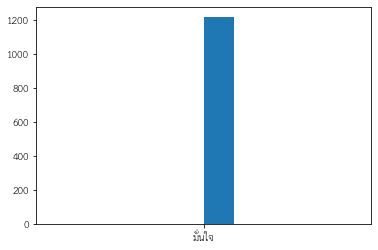

In [111]:
ret1_conf = plt.hist(assessor1['ความมั่นใจในการเมินราคาทรัพย์'])

##ให้คะแนนทรัพย์

In [113]:
link = 'https://docs.google.com/spreadsheets/d/1A3A-Yl4Tmcq2kPWf37QG6xdRZZ-4XDWULRPfORGPrNQ/export?format=xlsx'
home8= pd.read_excel(link,sheet_name='ชีต8')
home8.head()

,5,ขายง่าย ใช้ระยะเวลา 1-3 เดือน
0,4,ขายได้ ใช้ระยะเวลา 4-6 เดือน
1,3,ขายได้ ใช้ระยะเวลา 7-12 เดือน
2,2,ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี
3,1,ขายไม่ได้แน่นอน


# 2 ทำนายสภาพอากาศ 10 คะแนน
เตรียมข้อมูลเพื่อทำนายสภาพอากาศของวันถัดไป โดย 
- กลุ่มที่ 1 และ 9 ทำนาย อุณหภูมิตุ้มแห้ง (Y)
- กลุ่มที่ 2 ทำนาย อุณหภูมิต่ำสุด (Y)
- กลุ่มที่ 3 ทำนาย อุณหภูมิจุดน้ำค้าง (Y)
- กลุ่มที่ 4 ทำนาย จำนวนเมฆ (Y)
- กลุ่มที่ 5 ทำนาย ปริมาณฝน (Y)
- กลุ่มที่ 6 ทำนาย ความชื้นสัมพัทธ์ (Y)
- กลุ่มที่ 7 ทำนาย ความกด (Y)
- กลุ่มที่ 8 ทำนาย ความเร็วลม (Y)

ลักษณะของ data เป็นดังนี้ Xi คือ features อื่นๆที่ใช้ในทำนาย และ Y คือค่าที่ต้องการทำนาย

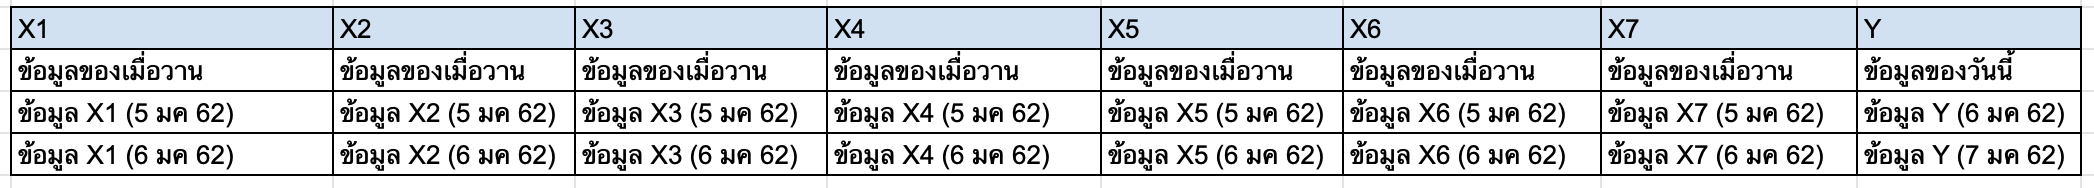



#Rain

In [ ]:
import pandas as pd
weather = pd.read_csv('